In [1]:
%matplotlib inline

This is a short example of how the DNA agarose gel electrophoresis in pydna can be used.
The %matplotlib inline in the line above is there to facilitate viewing matplotlib plots in    

## Pydna Gel Electrophoresis Simulation

In [2]:
import pydna

In [3]:
from pydna.gel import weight_standard_sample

In [4]:
st = weight_standard_sample('1kb+_GeneRuler')

In [5]:
gb = pydna.Genbank("bjornjobb@gmail.com")

In [6]:
gene = gb.nucleotide("X06997")

In [7]:
primer_f, primer_r = pydna.parse(''' >760_KlLAC12_rv (20-mer)
                                     ttaaacagattctgcctctg

                                     >759_KlLAC12_fw (19-mer)
                                     aaatggcagatcattcgag
                                     ''', ds=False)

In [8]:
# PCR
pcr_prod = pydna.pcr(primer_f, primer_r, gene)

In [9]:
pcr_prod

Dseqrecord(-1766)

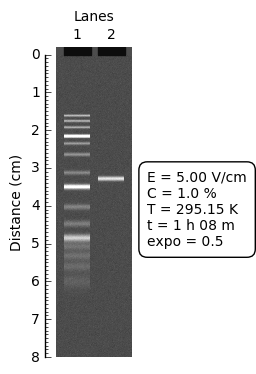

In [10]:
pydna.Gel([ st,[pcr_prod]] ).run()